In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Pathf
import pickle
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style("whitegrid")
sns.set_palette("husl")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
data_path = Path("../data")
ratings_df = pd.read_csv(data_path / "user_ratings.csv")

print(f"전체 데이터: {len(ratings_df):,}행")

user_counts = ratings_df['Username'].value_counts()
active_users = user_counts[user_counts >= 50].index

game_counts = ratings_df['BGGId'].value_counts()
popular_games = game_counts[game_counts >= 100].index

ratings_filtered = ratings_df[
    (ratings_df['Username'].isin(active_users)) & 
    (ratings_df['BGGId'].isin(popular_games))
].copy()

print(f"필터링 후 데이터: {len(ratings_filtered):,}행")

del ratings_df

# ID 매핑
user_to_id = {user: idx for idx, user in enumerate(ratings_filtered['Username'].unique())}
game_to_id = {game: idx for idx, game in enumerate(ratings_filtered['BGGId'].unique())}

ratings_filtered['user_id'] = ratings_filtered['Username'].map(user_to_id)
ratings_filtered['game_id'] = ratings_filtered['BGGId'].map(game_to_id)

n_users = len(user_to_id)
n_games = len(game_to_id)

print(f"사용자 수: {n_users:,}")
print(f"게임 수: {n_games:,}")

train_data, test_data = train_test_split(
    ratings_filtered[['user_id', 'game_id', 'Rating']], 
    test_size=0.2, 
    random_state=42
)

print(f"Train: {len(train_data):,}, Test: {len(test_data):,}")

전체 데이터: 18,942,215행
필터링 후 데이터: 14,733,960행
사용자 수: 93,637
게임 수: 12,302
Train: 11,787,168, Test: 2,946,792


### PyTorch Dataset 정의

In [5]:
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.users = torch.LongTensor(data['user_id'].values)
        self.games = torch.LongTensor(data['game_id'].values)
        self.ratings = torch.FloatTensor(data['Rating'].values)
    
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        return self.users[idx], self.games[idx], self.ratings[idx]

train_dataset = RatingsDataset(train_data)
test_dataset = RatingsDataset(test_data)

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Batch size: 2048
Train batches: 5756
Test batches: 1439


### NCF 모델 정의

In [6]:
class NCF(nn.Module):
    def __init__(self, n_users, n_games, embedding_dim=64, hidden_layers=[128, 64, 32]):
        super(NCF, self).__init__()
        
        # Embedding layers
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.game_embedding = nn.Embedding(n_games, embedding_dim)
        
        # MLP layers
        self.fc_layers = nn.ModuleList()
        input_size = embedding_dim * 2
        
        for hidden_size in hidden_layers:
            self.fc_layers.append(nn.Linear(input_size, hidden_size))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Dropout(0.2))
            input_size = hidden_size
        
        # Output layer
        self.output = nn.Linear(hidden_layers[-1], 1)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.game_embedding.weight, std=0.01)
        
        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0)
    
    def forward(self, user_ids, game_ids):
        user_emb = self.user_embedding(user_ids)
        game_emb = self.game_embedding(game_ids)
        
        x = torch.cat([user_emb, game_emb], dim=1)
        
        for layer in self.fc_layers:
            x = layer(x)
        
        output = self.output(x)
        return output.squeeze()

# 모델 초기화
embedding_dim = 64
hidden_layers = [128, 64, 32]

model = NCF(n_users, n_games, embedding_dim, hidden_layers).to(device)

print(f"모델 구조:")
print(f"  - User Embedding: {n_users} x {embedding_dim}")
print(f"  - Game Embedding: {n_games} x {embedding_dim}")
print(f"  - Hidden Layers: {hidden_layers}")
print(f"  - 총 파라미터: {sum(p.numel() for p in model.parameters()):,}")


모델 구조:
  - User Embedding: 93637 x 64
  - Game Embedding: 12302 x 64
  - Hidden Layers: [128, 64, 32]
  - 총 파라미터: 6,806,977


In [7]:
#학습 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"손실 함수: MSE")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-5)")

손실 함수: MSE
Optimizer: Adam (lr=0.001, weight_decay=1e-5)


In [8]:
# 학습함수
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for user_ids, game_ids, ratings in loader:
        user_ids = user_ids.to(device)
        game_ids = game_ids.to(device)
        ratings = ratings.to(device)
        
        optimizer.zero_grad()
        predictions = model(user_ids, game_ids)
        loss = criterion(predictions, ratings)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for user_ids, game_ids, ratings in loader:
            user_ids = user_ids.to(device)
            game_ids = game_ids.to(device)
            
            preds = model(user_ids, game_ids)
            
            predictions.extend(preds.cpu().numpy())
            actuals.extend(ratings.numpy())
    
    predictions = np.array(predictions).clip(1, 10)
    actuals = np.array(actuals)
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    
    return rmse, mae, predictions, actuals

### 모델학습

In [9]:
n_epochs = 10
patience = 3
best_rmse = float('inf')
patience_counter = 0
best_epoch = 0

train_losses = []
test_rmses = []
test_maes = []

print(f"Epochs: {n_epochs}")
print(f"Early Stopping Patience: {patience}")
print("\nEpoch | Train Loss | Test RMSE | Test MAE | Time")
print("-" * 60)

import time

for epoch in range(n_epochs):
    start_time = time.time()
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    test_rmse, test_mae, _, _ = evaluate(model, test_loader, device)
    
    train_losses.append(train_loss)
    test_rmses.append(test_rmse)
    test_maes.append(test_mae)
    
    elapsed = time.time() - start_time
    
    print(f"{epoch+1:5d} | {train_loss:10.4f} | {test_rmse:9.4f} | {test_mae:8.4f} | {elapsed:.1f}s")
    
    # Early Stopping 로직
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_epoch = epoch
        patience_counter = 0
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'epoch': epoch,
            'best_rmse': best_rmse
        }, Path("../outputs/models") / 'ncf_model_best.pth')
        print(f"  → 최고 성능 모델 저장 (RMSE: {best_rmse:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

print(f"최고 성능 에포크: {best_epoch+1}/{n_epochs}, RMSE: {best_rmse:.4f}")

Epochs: 10
Early Stopping Patience: 3

Epoch | Train Loss | Test RMSE | Test MAE | Time
------------------------------------------------------------
    1 |     2.2259 |    1.1554 |   0.8694 | 454.1s
  → 최고 성능 모델 저장 (RMSE: 1.1554)
    2 |     1.4765 |    1.1384 |   0.8533 | 682.9s
  → 최고 성능 모델 저장 (RMSE: 1.1384)
    3 |     1.3126 |    1.1316 |   0.8454 | 916.7s
  → 최고 성능 모델 저장 (RMSE: 1.1316)
    4 |     1.2745 |    1.1217 |   0.8359 | 727.6s
  → 최고 성능 모델 저장 (RMSE: 1.1217)
    5 |     1.2443 |    1.1173 |   0.8355 | 438.8s
  → 최고 성능 모델 저장 (RMSE: 1.1173)
    6 |     1.2266 |    1.1112 |   0.8303 | 530.4s
  → 최고 성능 모델 저장 (RMSE: 1.1112)
    7 |     1.2137 |    1.1106 |   0.8295 | 447.7s
  → 최고 성능 모델 저장 (RMSE: 1.1106)
    8 |     1.2024 |    1.1070 |   0.8250 | 464.1s
  → 최고 성능 모델 저장 (RMSE: 1.1070)
    9 |     1.1920 |    1.1052 |   0.8244 | 426.5s
  → 최고 성능 모델 저장 (RMSE: 1.1052)
   10 |     1.1836 |    1.1061 |   0.8247 | 444.7s
최고 성능 에포크: 9/10, RMSE: 1.1052


### 최종 평가

In [14]:
final_rmse, final_mae, predictions, actuals = evaluate(model, test_loader, device)

print(f"최종 Test RMSE: {final_rmse:.4f}")
print(f"최종 Test MAE: {final_mae:.4f}")

# Baseline 비교
baseline_rmse = 1.1960  # User + Game Bias
improvement = (baseline_rmse - final_rmse) / baseline_rmse * 100

print(f"\nBaseline 대비:")
print(f"  - Baseline RMSE: {baseline_rmse:.4f}")
print(f"  - NCF RMSE: {final_rmse:.4f}")
print(f"  - 개선율: {improvement:.2f}%")

최종 Test RMSE: 1.1061
최종 Test MAE: 0.8247

Baseline 대비:
  - Baseline RMSE: 1.1960
  - NCF RMSE: 1.1061
  - 개선율: 7.52%


### 시각화

저장: ..\outputs\figures\05_ncf_training.png


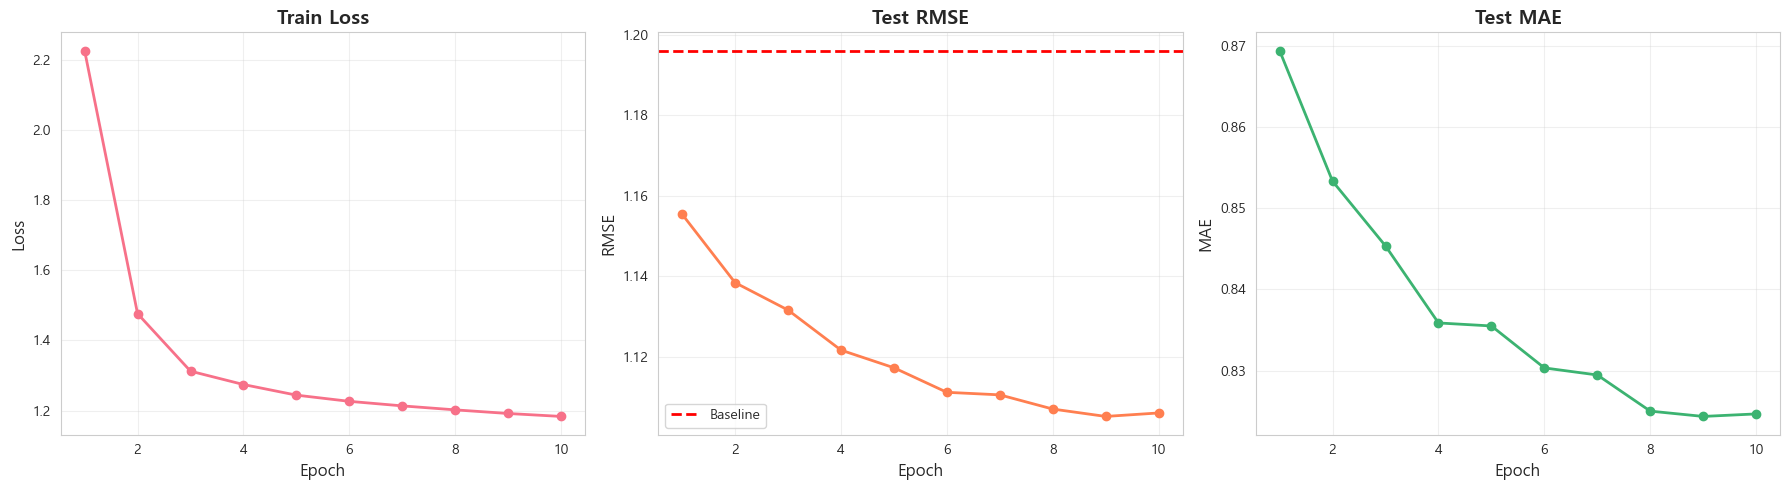

저장: ..\outputs\figures\06_ncf_predictions.png


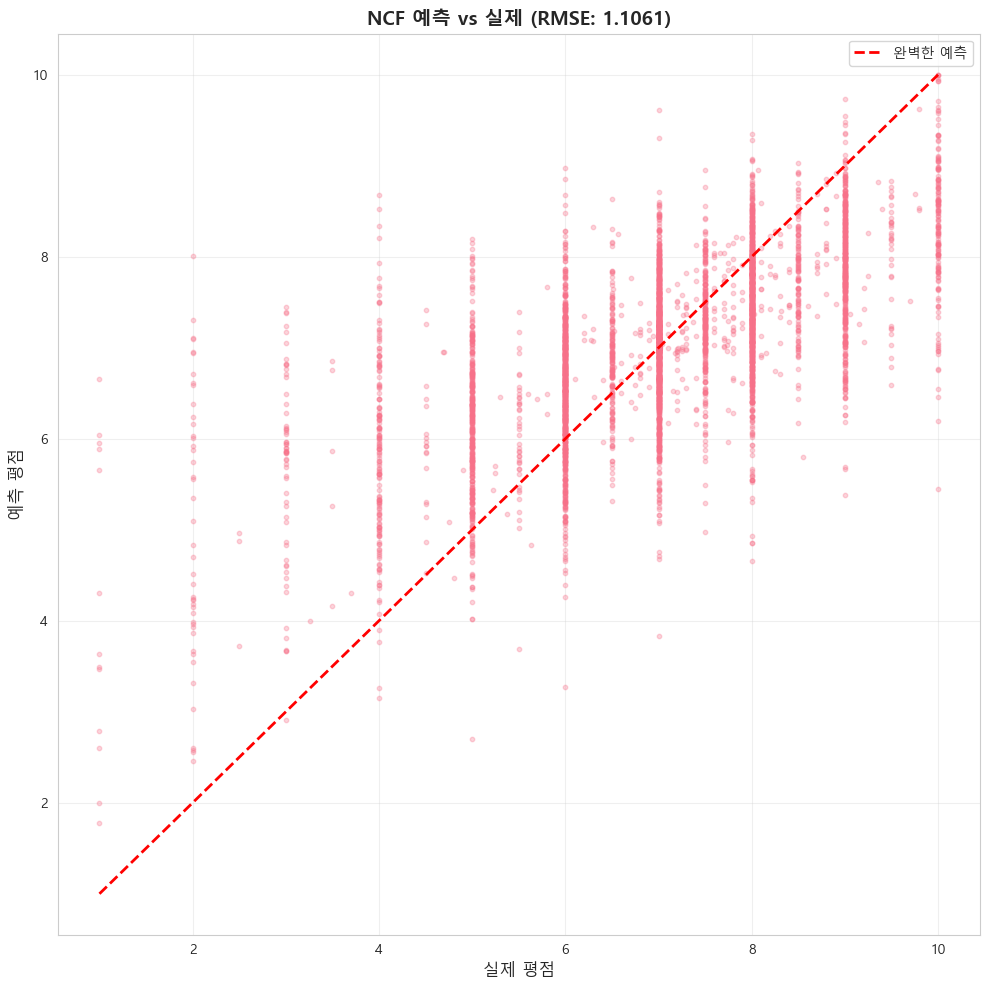

In [15]:
output_path = Path("../outputs/figures")
output_path.mkdir(parents=True, exist_ok=True)

# Figure 1: 학습 곡선
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train Loss
axes[0].plot(range(1, n_epochs+1), train_losses, 'o-', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Train Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test RMSE
axes[1].plot(range(1, n_epochs+1), test_rmses, 'o-', linewidth=2, markersize=6, color='coral')
axes[1].axhline(y=baseline_rmse, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('Test RMSE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Test MAE
axes[2].plot(range(1, n_epochs+1), test_maes, 'o-', linewidth=2, markersize=6, color='mediumseagreen')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('MAE', fontsize=12)
axes[2].set_title('Test MAE', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_path / '05_ncf_training.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '05_ncf_training.png'}")
plt.show()
plt.close()

# Figure 2: 예측 vs 실제
fig, ax = plt.subplots(figsize=(10, 10))

sample_size = min(5000, len(predictions))
sample_idx = np.random.choice(len(predictions), sample_size, replace=False)

ax.scatter(actuals[sample_idx], predictions[sample_idx], alpha=0.3, s=10)
ax.plot([1, 10], [1, 10], 'r--', linewidth=2, label='완벽한 예측')
ax.set_xlabel('실제 평점', fontsize=12)
ax.set_ylabel('예측 평점', fontsize=12)
ax.set_title(f'NCF 예측 vs 실제 (RMSE: {final_rmse:.4f})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_path / '06_ncf_predictions.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '06_ncf_predictions.png'}")
plt.show()
plt.close()

### 모델 저장

In [16]:
output_models_path = Path("../outputs/models")
output_models_path.mkdir(parents=True, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'n_users': n_users,
    'n_games': n_games,
    'embedding_dim': embedding_dim,
    'hidden_layers': hidden_layers,
    'user_to_id': user_to_id,
    'game_to_id': game_to_id,
    'final_rmse': final_rmse,
    'final_mae': final_mae
}, output_models_path / 'ncf_model.pth')

print(f"저장: {output_models_path / 'ncf_model.pth'}")

results_df = pd.DataFrame({
    'epoch': range(1, n_epochs+1),
    'train_loss': train_losses,
    'test_rmse': test_rmses,
    'test_mae': test_maes
})

results_df.to_csv(Path("../outputs/reports") / 'ncf_training_results.csv', index=False)
print(f"저장: ../outputs/reports/ncf_training_results.csv")


저장: ..\outputs\models\ncf_model.pth
저장: ../outputs/reports/ncf_training_results.csv


In [17]:
print("\n최종 성능:")
print(f"   RMSE: {final_rmse:.4f}")
print(f"   MAE: {final_mae:.4f}")
print(f"   Baseline 대비 개선: {improvement:.2f}%")

print("\n생성된 파일:")
print(f"   [시각화]")
print(f"   - {output_path / '05_ncf_training.png'}")
print(f"   - {output_path / '06_ncf_predictions.png'}")
print(f"   [모델]")
print(f"   - {output_models_path / 'ncf_model.pth'}")
print(f"   [보고서]")
print(f"   - ../outputs/reports/ncf_training_results.csv")



최종 성능:
   RMSE: 1.1061
   MAE: 0.8247
   Baseline 대비 개선: 7.52%

생성된 파일:
   [시각화]
   - ..\outputs\figures\05_ncf_training.png
   - ..\outputs\figures\06_ncf_predictions.png
   [모델]
   - ..\outputs\models\ncf_model.pth
   [보고서]
   - ../outputs/reports/ncf_training_results.csv
